In [1]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from transformers import RobertaTokenizer, RobertaModel
from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from torch.optim.lr_scheduler import OneCycleLR

# Load Data
df = pd.read_csv("/kaggle/input/walmart-dataset/zero_shot_labeled_reviews_final.csv")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Use ORIGINAL reviews, not cleaned ones
texts = df["Review"].astype(str).tolist()
labels_raw = df["Emotion"].tolist()
label2id = {label: i for i, label in enumerate(sorted(set(labels_raw)))}
df["Label"] = df["Emotion"].map(label2id)
labels = df["Label"].tolist()
num_classes = len(label2id)

# Class weights
class_weights = compute_class_weight('balanced', classes=np.unique(labels), y=labels)
class_weights = torch.tensor(class_weights, dtype=torch.float).to(device)

# Tokenizer
tokenizer = RobertaTokenizer.from_pretrained("roberta-base")

# Dataset
class ReviewDataset(Dataset):
    def _init_(self, texts, labels, tokenizer, max_len=256):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def _len_(self): return len(self.texts)

    def _getitem_(self, idx):
        encoding = self.tokenizer(
            self.texts[idx],
            max_length=self.max_len,
            padding="max_length",
            truncation=True,
            return_tensors="pt"
        )
        return {
            "input_ids": encoding["input_ids"].squeeze(0),
            "attention_mask": encoding["attention_mask"].squeeze(0),
            "label": torch.tensor(self.labels[idx], dtype=torch.long)
        }

# Data split
train_texts, val_texts, train_labels, val_labels = train_test_split(
    texts, labels, test_size=0.2, stratify=labels, random_state=42
)
train_dataset = ReviewDataset(train_texts, train_labels, tokenizer)
val_dataset = ReviewDataset(val_texts, val_labels, tokenizer)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32)

# Model
class RoBERTaBiLSTMAttn(nn.Module):
    def _init_(self, num_classes, hidden_dim=256, num_layers=2):
        super()._init_()
        self.roberta = RobertaModel.from_pretrained("roberta-base")
        self.lstm = nn.LSTM(768, hidden_dim, num_layers=num_layers,
                            batch_first=True, dropout=0.3, bidirectional=True)
        self.attn = nn.Linear(hidden_dim * 2, 1)
        self.fc1 = nn.Linear(hidden_dim * 2 + 768, hidden_dim)
        self.gelu = nn.GELU()
        self.fc_out = nn.Linear(hidden_dim, num_classes)
        self.dropout = nn.Dropout(0.5)

    def forward(self, input_ids, attention_mask):
        roberta_out = self.roberta(input_ids=input_ids, attention_mask=attention_mask)
        seq_output = roberta_out.last_hidden_state
        pooled_output = roberta_out.pooler_output if roberta_out.pooler_output is not None else seq_output[:, 0]

        lstm_out, _ = self.lstm(seq_output)
        attn_weights = torch.softmax(self.attn(lstm_out).squeeze(-1), dim=1)
        context_vector = torch.sum(attn_weights.unsqueeze(-1) * lstm_out, dim=1)

        combined = torch.cat([context_vector, pooled_output], dim=1)
        x = self.dropout(self.gelu(self.fc1(combined)))
        return self.fc_out(self.dropout(x))

model = RoBERTaBiLSTMAttn(num_classes).to(device)

# Optimizer & Scheduler
optimizer = optim.AdamW(model.parameters(), lr=2e-5, weight_decay=0.01)
total_steps = len(train_loader) * 10  # 10 epochs
scheduler = OneCycleLR(optimizer, max_lr=2e-5, steps_per_epoch=len(train_loader), epochs=10)

# Loss
criterion = nn.CrossEntropyLoss(weight=class_weights)

# Training loop
def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, epochs=10):
    best_val_acc = 0
    patience = 0

    for epoch in range(epochs):
        model.train()
        total_loss, correct = 0, 0

        for batch in train_loader:
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["label"].to(device)

            optimizer.zero_grad()
            outputs = model(input_ids, attention_mask)
            loss = criterion(outputs, labels)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()
            scheduler.step()

            total_loss += loss.item()
            correct += (outputs.argmax(1) == labels).sum().item()

        train_acc = correct / len(train_loader.dataset)

        # Validation
        model.eval()
        val_correct, val_preds, val_true = 0, [], []
        with torch.no_grad():
            for batch in val_loader:
                input_ids = batch["input_ids"].to(device)
                attention_mask = batch["attention_mask"].to(device)
                labels = batch["label"].to(device)

                outputs = model(input_ids, attention_mask)
                val_preds.extend(outputs.argmax(1).cpu().numpy())
                val_true.extend(labels.cpu().numpy())
                val_correct += (outputs.argmax(1) == labels).sum().item()

        val_acc = val_correct / len(val_loader.dataset)
        print(f"Epoch {epoch+1} - Train Acc: {train_acc:.4f} | Val Acc: {val_acc:.4f}")

        if val_acc > best_val_acc:
            best_val_acc = val_acc
            torch.save(model.state_dict(), "best_roberta_bilstm_model.pth")
            print("Model improved and saved.")
            patience = 0
        else:
            patience += 1
            print(f" No improvement. Patience {patience}/5")
            if patience >= 5:
                print("Early stopping.")
                break

    print("\n Final Classification Report:")
    print(classification_report(val_true, val_preds, target_names=label2id.keys()))

# Train It
train_model(model, train_loader, val_loader, criterion, optimizer, scheduler)


import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

def evaluate_model(model, val_loader, criterion):
    model.eval()
    val_loss, val_correct = 0, 0
    all_preds, all_labels = [], []
    
    with torch.no_grad():
        for batch in val_loader:
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["label"].to(device)
            
            outputs = model(input_ids, attention_mask)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            val_correct += (outputs.argmax(1) == labels).sum().item()
            
            all_preds.extend(outputs.argmax(1).cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    val_acc = val_correct / len(val_dataset)
    print(f"Validation Loss: {val_loss / len(val_loader):.4f}, Validation Accuracy: {val_acc:.4f}")

    # Generate confusion matrix
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap="Blues", xticklabels=emotion_labels.keys(), yticklabels=emotion_labels.keys())
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("Confusion Matrix")
    plt.show()

    # Print classification report
    print("\nClassification Report:\n", classification_report(all_labels, all_preds, target_names=emotion_labels.keys()))

# Run evaluation
evaluate_model(model, val_loader, criterion)

2025-04-13 15:46:17.472324: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1744559177.678118      31 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1744559177.737647      31 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

TypeError: ReviewDataset() takes no arguments

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/20 - Train Acc: 0.1036 | Val Acc: 0.1198
Model improved and saved.
Epoch 2/20 - Train Acc: 0.2556 | Val Acc: 0.5255
Model improved and saved.
Epoch 3/20 - Train Acc: 0.3874 | Val Acc: 0.4771
No improvement. Patience 1/5
Epoch 4/20 - Train Acc: 0.4388 | Val Acc: 0.5665
Model improved and saved.
Epoch 5/20 - Train Acc: 0.4897 | Val Acc: 0.4756
No improvement. Patience 1/5
Epoch 6/20 - Train Acc: 0.5627 | Val Acc: 0.6043
Model improved and saved.
Epoch 7/20 - Train Acc: 0.6632 | Val Acc: 0.5977
No improvement. Patience 1/5
Epoch 8/20 - Train Acc: 0.7362 | Val Acc: 0.5486
No improvement. Patience 2/5
Epoch 9/20 - Train Acc: 0.7990 | Val Acc: 0.6838
Model improved and saved.
Epoch 10/20 - Train Acc: 0.8385 | Val Acc: 0.7479
Model improved and saved.
Epoch 11/20 - Train Acc: 0.8791 | Val Acc: 0.7501
Model improved and saved.
Epoch 12/20 - Train Acc: 0.9064 | Val Acc: 0.7706
Model improved and saved.
Epoch 13/20 - Train Acc: 0.9294 | Val Acc: 0.7761
Model improved and saved.
Epoch 14/

/tmp/ipykernel_31/2747679341.py:171: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("best_roberta_bilstm_model.pth"))


Validation Loss: 2.2514, Validation Accuracy: 0.7977


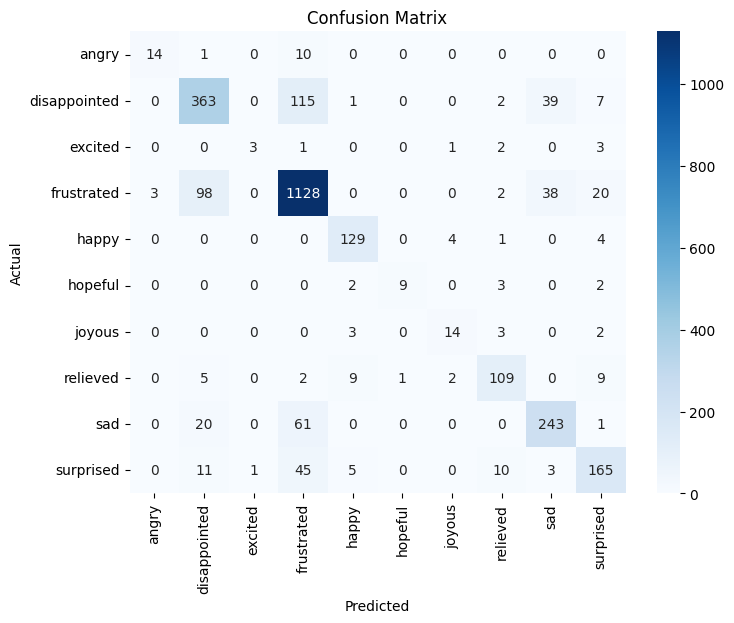


Classification Report:
               precision    recall  f1-score   support

       angry       0.82      0.56      0.67        25
disappointed       0.73      0.69      0.71       527
     excited       0.75      0.30      0.43        10
  frustrated       0.83      0.88      0.85      1289
       happy       0.87      0.93      0.90       138
     hopeful       0.90      0.56      0.69        16
      joyous       0.67      0.64      0.65        22
    relieved       0.83      0.80      0.81       137
         sad       0.75      0.75      0.75       325
   surprised       0.77      0.69      0.73       240

    accuracy                           0.80      2729
   macro avg       0.79      0.68      0.72      2729
weighted avg       0.80      0.80      0.80      2729



In [2]:
---------------------------------------------------------------------------
NameError                                 Traceback (most recent call last)
/tmp/ipykernel_31/1728170082.py in <cell line: 0>()
      5 
      6 # Binarize the labels
----> 7 y_test_bin = label_binarize(all_labels, classes=list(range(num_classes)))
      8 y_score = []
      9 

NameError: name 'all_labels' is not defined

/tmp/ipykernel_31/1811182974.py:9: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("best_roberta_bilstm_model.pth"))


Validation Loss: 2.2514, Validation Accuracy: 0.7977


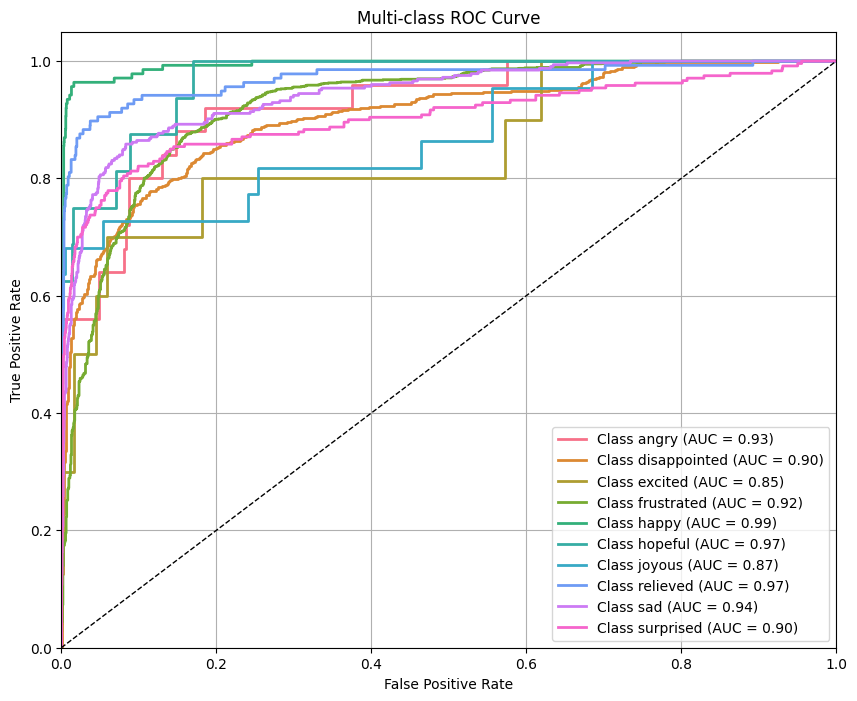

In [6]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import numpy as np
from itertools import cycle
import seaborn as sns

def evaluate_model_with_roc(model, val_loader, criterion, num_classes, id2label):
    model.load_state_dict(torch.load("best_roberta_bilstm_model.pth"))
    model.eval()
    val_loss, val_correct = 0, 0
    all_preds, all_labels, all_probs = [], [], []

    with torch.no_grad():
        for batch in val_loader:
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["label"].to(device)

            outputs = model(input_ids, attention_mask)
            probs = torch.softmax(outputs, dim=1)
            loss = criterion(outputs, labels)

            val_loss += loss.item()
            val_correct += (outputs.argmax(1) == labels).sum().item()
            all_preds.extend(outputs.argmax(1).cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            all_probs.extend(probs.cpu().numpy())

    val_acc = val_correct / len(val_loader.dataset)
    print(f"Validation Loss: {val_loss / len(val_loader):.4f}, Validation Accuracy: {val_acc:.4f}")

    # ROC Curve
    y_test_bin = label_binarize(all_labels, classes=list(range(num_classes)))
    y_score = np.array(all_probs)

    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(num_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    plt.figure(figsize=(10, 8))
    colors = cycle(sns.color_palette("husl", num_classes))
    for i, color in zip(range(num_classes), colors):
        plt.plot(fpr[i], tpr[i], color=color, lw=2,
                 label=f"Class {id2label[i]} (AUC = {roc_auc[i]:.2f})")

    plt.plot([0, 1], [0, 1], 'k--', lw=1)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Multi-class ROC Curve')
    plt.legend(loc="lower right")
    plt.grid()
    plt.show()

# Call the function
evaluate_model_with_roc(model, val_loader, criterion, num_classes, id2label)

In [8]:
from sklearn.metrics import accuracy_score
import numpy as np

model.load_state_dict(torch.load("best_roberta_bilstm_model.pth"))
model.eval()

all_preds = []
all_labels = []

with torch.no_grad():
    for batch in val_loader:
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["label"].to(device)

        outputs = model(input_ids, attention_mask)
        preds = outputs.argmax(1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Convert to numpy arrays
all_preds = np.array(all_preds)
all_labels = np.array(all_labels)

# Per-Class Accuracy
print("\nPer-Class Accuracy:")
for class_idx in range(num_classes):
    class_name = id2label[class_idx]
    idx = (all_labels == class_idx)
    acc = accuracy_score(all_labels[idx], all_preds[idx])
    print(f"{class_name}: {acc:.4f}")

/tmp/ipykernel_31/1110184285.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("best_roberta_bilstm_model.pth"))



Per-Class Accuracy:
angry: 0.5600
disappointed: 0.6888
excited: 0.3000
frustrated: 0.8751
happy: 0.9348
hopeful: 0.5625
joyous: 0.6364
relieved: 0.7956
sad: 0.7477
surprised: 0.6875


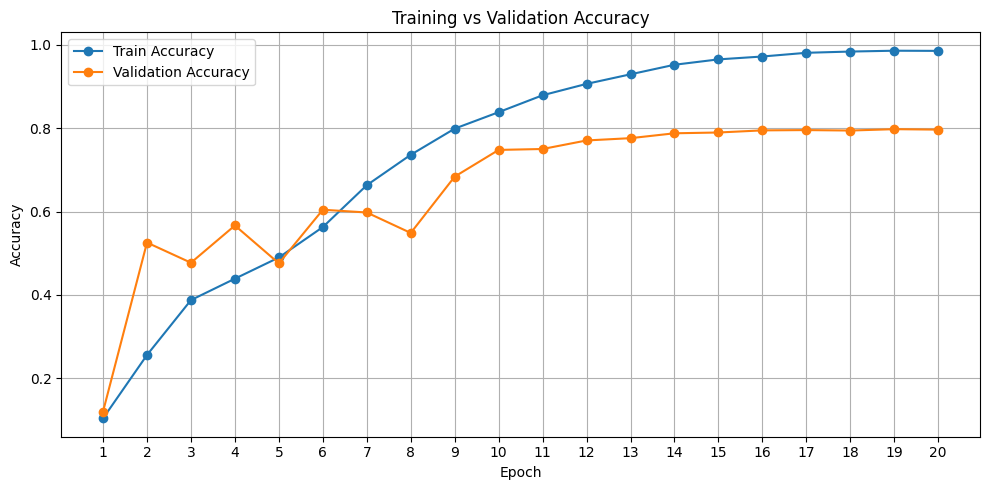

In [28]:
import re
import matplotlib.pyplot as plt

log_data = """
Epoch 1/20 - Train Acc: 0.1036 | Val Acc: 0.1198
Model improved and saved.
Epoch 2/20 - Train Acc: 0.2556 | Val Acc: 0.5255
Model improved and saved.
Epoch 3/20 - Train Acc: 0.3874 | Val Acc: 0.4771
No improvement. Patience 1/5
Epoch 4/20 - Train Acc: 0.4388 | Val Acc: 0.5665
Model improved and saved.
Epoch 5/20 - Train Acc: 0.4897 | Val Acc: 0.4756
No improvement. Patience 1/5
Epoch 6/20 - Train Acc: 0.5627 | Val Acc: 0.6043
Model improved and saved.
Epoch 7/20 - Train Acc: 0.6632 | Val Acc: 0.5977
No improvement. Patience 1/5
Epoch 8/20 - Train Acc: 0.7362 | Val Acc: 0.5486
No improvement. Patience 2/5
Epoch 9/20 - Train Acc: 0.7990 | Val Acc: 0.6838
Model improved and saved.
Epoch 10/20 - Train Acc: 0.8385 | Val Acc: 0.7479
Model improved and saved.
Epoch 11/20 - Train Acc: 0.8791 | Val Acc: 0.7501
Model improved and saved.
Epoch 12/20 - Train Acc: 0.9064 | Val Acc: 0.7706
Model improved and saved.
Epoch 13/20 - Train Acc: 0.9294 | Val Acc: 0.7761
Model improved and saved.
Epoch 14/20 - Train Acc: 0.9523 | Val Acc: 0.7878
Model improved and saved.
Epoch 15/20 - Train Acc: 0.9652 | Val Acc: 0.7897
Model improved and saved.
Epoch 16/20 - Train Acc: 0.9721 | Val Acc: 0.7948
Model improved and saved.
Epoch 17/20 - Train Acc: 0.9810 | Val Acc: 0.7955
Model improved and saved.
Epoch 18/20 - Train Acc: 0.9840 | Val Acc: 0.7944
No improvement. Patience 1/5
Epoch 19/20 - Train Acc: 0.9860 | Val Acc: 0.7977
Model improved and saved.
Epoch 20/20 - Train Acc: 0.9856 | Val Acc: 0.7966
No improvement. Patience 1/5
"""

train_accuracies = []
val_accuracies = []

for line in log_data.strip().split('\n'):
    match = re.search(r"Train Acc: ([0-9.]+) \| Val Acc: ([0-9.]+)", line)
    if match:
        train_accuracies.append(float(match.group(1)))
        val_accuracies.append(float(match.group(2)))

epochs = list(range(1, len(train_accuracies) + 1))

plt.figure(figsize=(10, 5))
plt.plot(epochs, train_accuracies, marker='o', label='Train Accuracy')
plt.plot(epochs, val_accuracies, marker='o', label='Validation Accuracy')
plt.title('Training vs Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.xticks(epochs)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

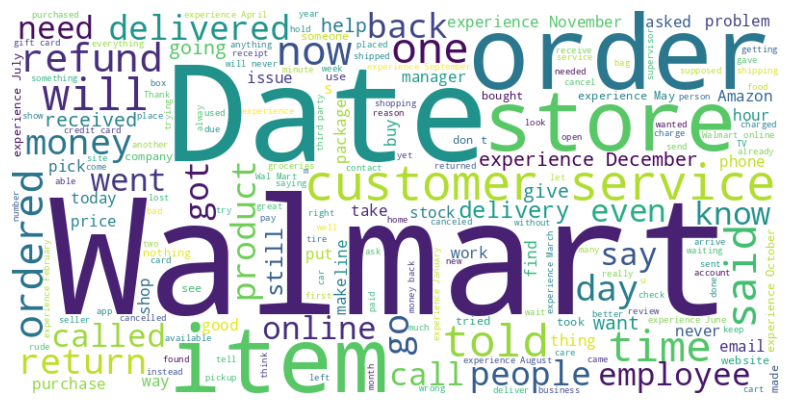

In [35]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Generate a word cloud for the reviews
def generate_word_cloud(texts):
    # Combine all reviews into a single string
    text = " ".join(texts)
    
    # Create a word cloud object
    wordcloud = WordCloud(width=800, height=400, background_color="white").generate(text)
    
    # Display the word cloud
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.show()

# Call the function with the reviews from the dataset
generate_word_cloud(texts)